# 코랩 내 TPU를 사용하여 학습

In [ ]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!echo $COLAB_TPU_ADDR

In [ ]:
import tensorflow as tf

# TPU gRPC 접근 URI
TPU_PATH = f"grpc://{os.environ['COLAB_TPU_ADDR']}"

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_PATH)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
from PIL import Image
import os, glob, sys
import numpy as np
from sklearn.model_selection import train_test_split # 섞어줌
from keras.utils import np_utils

In [ ]:
# 고양이, 개, 소, 닭 구별하는 전처리 파일.
# train set 0.9, test set 0.1

X_train, X_test, y_train, y_test = np.load('.npy', allow_pickle=True)

# 데이터 정규화
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
# resNet 모델 작성
def model_res():

    def indentity_block(X, f, filters):
        
        # 필터 갯수
        F1, F2, F3 = filters

        # X 저장 
        X_shortcut = X

        ### F(X) ###
        # 첫번째 conv layer
        X = Conv2D(F1, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 두번쨰 conv layer
        X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 세번째 conv layer
        X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)

        # F(X) + X
        # 첫번째와 세번째는 1x1이고 두번째는 padding이 same 이므로 shape는 동일하다.
        X = layers.Add()([X, X_shortcut])
        X = layers.Activation('relu')(X)

        return X

    def Conv_Block(X, f, filters, s = 2):
        
        # 필터 갯수
        F1, F2, F3 = filters

        # X 저장
        X_shortcut = X

        ### F(X) ###
        # 첫번째 conv layer
        X = Conv2D(F1, (1, 1), strides = (s, s), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 두번쨰 conv layer
        X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 세번째 conv layer
        X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        
        ### G(X) ###
        # shortcut layer
        X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding= 'valid')(X_shortcut)   
        X_shortcut = layers.BatchNormalization(axis = 3)(X_shortcut)

        # F(X) + G(X)
        X = layers.Add()([X, X_shortcut])
        X = layers.Activation('relu')(X)

        return X 

    # ppt 104~106 페이지에 따르면, resNet50 은 다음과 같은 구조이다.
    # 0. (3,3) 제로 패딩
    # 1. Conv2D 사용. s = 2인 7x7 크기 필터 64개, 배치 정규화, relu 사용, MaxPooling 사용
    # 2. Conv_Block 사용. s = 1인 3x3 크기 필터 64x64x256개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 64x64x256개 사용
    # 3. Conv_Block 사용. s = 2인 3x3 크기 필터 128x128x512개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 128x128x512개 사용
    # 4. Conv_Block 사용. s = 2인 3x3 크기 필터 256x256x1024개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    # 5. Conv_Block 사용. s = 2인 3x3 크기 필터 512x512x2048개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    # 6. AveragePooling 사용. 2x2
    # 7. Dense layer

    input_img = Input((64, 64, 3))

    # 0. (3,3) 제로 패딩
    # 1. Conv2D 사용. s = 2인 7x7 크기 필터 64개, 배치 정규화, relu 사용, MaxPooling 사용
    X = Conv2D(64, (7, 7), strides = (2, 2), padding = (3, 3))(input_img)
    X = layers.BatchNormalization(axis = 3)(X)
    X = layers.Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2, 2))(X)

    # 2. Conv_Block 사용. s = 1인 3x3 크기 필터 64x64x256개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 64x64x256개 사용
    X = Conv_Block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = indentity_block(X, 3, [64, 64, 256])
    X = indentity_block(X, 3, [64, 64, 256])

    # 3. Conv_Block 사용. s = 2인 3x3 크기 필터 128x128x512개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 128x128x512개 사용
    X = Conv_Block(X, 3, [128, 128, 512])
    X = indentity_block(X, 3, [128, 128, 512])
    X = indentity_block(X, 3, [128, 128, 512])

    # 4. Conv_Block 사용. s = 2인 3x3 크기 필터 256x256x1024개 사용
    #    indentity_block 5번 사용. 3x3 크기 필터 256x256x1024개 사용
    X = Conv_Block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])

    # 5. Conv_Block 사용. s = 2인 3x3 크기 필터 512x512x2048개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    X = Conv_Block(X, 3, [512, 512, 2048])
    X = indentity_block(X, 3, [512, 512, 2048])
    X = indentity_block(X, 3, [512, 512, 2048])
    
    # 6. AveragePooling 사용. 2x2
    X = AveragePooling2D(2, 2)(X)

    # 7. Dense layer
    X = Flatten()(X)
    out = Dense(4, activation="softmax")(X)

    model = Model(inputs = input_img, outputs = out)

    return model

In [ ]:
model_res().summary()

In [ ]:
with strategy.scope():

    early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

    model = model_res()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    history = model.fit(X_train, y_train, callbacks=[early_stopping], batch_size=50, validation_data = (X_test,y_test), epochs = 100)

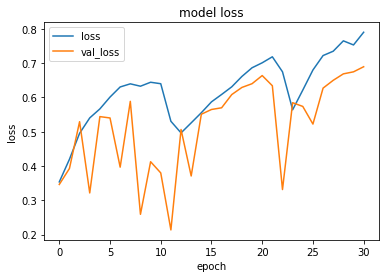

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', "accuracy", 'val_accuracy'], loc='upper left')
plt.show()